<a href="https://colab.research.google.com/github/aaronszypulagastro/Malaria-Erkennung-aus-Zellbildern/blob/main/Malaria_Erkennung_aus_Zellbildern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [109]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam

# **Datenvorbereitung**

In [130]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [129]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))



[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), np.int64(1))] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0,

In [131]:
IMG_SIZE = 224
BATCH_SIZE = 32

def resize_rescale(image, label):
    # Bild auf 224x224 resizen und Werte auf 0-1 skalieren
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

train_dataset = train_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



# **Datenvisualiserung**

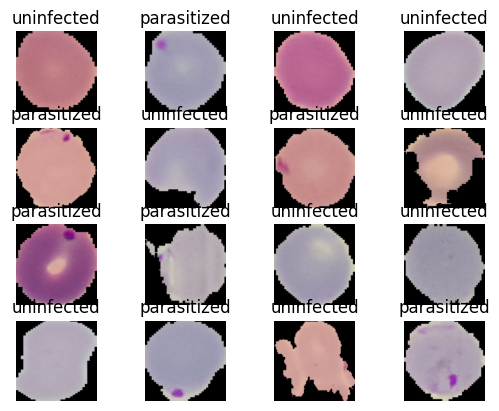

In [132]:
for i, (image_batch, label_batch) in enumerate(train_dataset.take(16)):
    # Take the first image and label from the batch
    image = image_batch[0]
    label = label_batch[0]

    ax = plt.subplot(4,4, i+1)
    plt.imshow(image.numpy().astype("float32"))
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

plt.show()



# **Datenvorverarbeitung**

In [134]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

# **Modelerstellung**

In [116]:
# Hinweis: Das Modell wird mit weniger Epochen trainiert,
# da die verfügbare Rechenleistung begrenzt ist.

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMG_SIZE,IMG_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides= 1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides= 1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dropout(0.5),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),
])
lenet_model.summary()




/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [117]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.5, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred).numpy()

np.float32(5.091308)

In [118]:
lenet_model.compile(optimizer= Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])



In [119]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 10, verbose = 1)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.8028 - loss: 0.4383 - val_accuracy: 0.9042 - val_loss: 0.3334
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9105 - loss: 0.2482 - val_accuracy: 0.7982 - val_loss: 0.4383
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9210 - loss: 0.2232 - val_accuracy: 0.9169 - val_loss: 0.2241
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9291 - loss: 0.2014 - val_accuracy: 0.9347 - val_loss: 0.2175
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9364 - loss: 0.1835 - val_accuracy: 0.9452 - val_loss: 0.1588
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.9496 - loss: 0.1400 - val_accuracy: 0.9390 - val_loss: 0.1693
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.9593 - loss: 0.1115 - val_accuracy: 0.9510 - val_loss: 0.1636
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9700 - loss: 0.0871 - 

**Problem:** Modell hängt bei 50% Accuracy, das bedeutet das es die Antworten nur rät.

**Mögliche Ursache:**
*   Fehler bei den Daten (Labels oder Normalisierung)
*   Modell bekommt die Daten im falschen Format

**Vorschlag:**
Labels und Bilder checken auf mögliche falsche Formatierung

**Antwort:**
Fehler im Code, die Bilder wurden zwei mal normalisert


In [120]:
# for images, labels in train_dataset.take(1):
#     print(labels[:10].numpy())

# for images, labels in train_dataset.take(1):
#     print(images.numpy().min(), images.numpy().max())

# **Visualisierung der Ergebnisse**

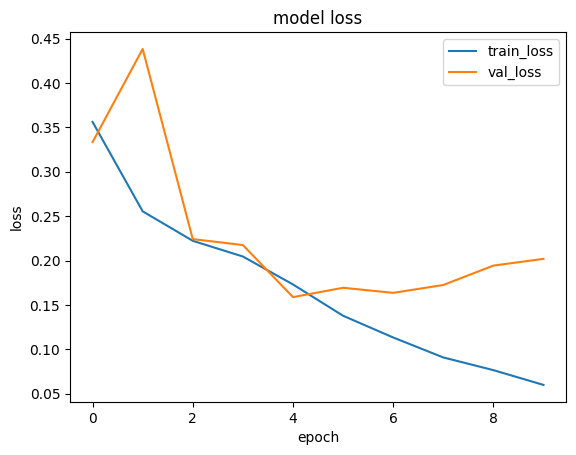

In [121]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

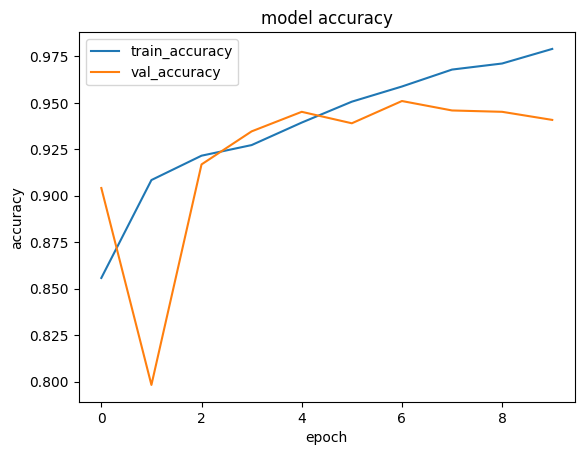

In [122]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **Model Evaluation**

In [135]:
lenet_model.evaluate(test_dataset)


87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.9391 - loss: 0.2336


[0.2460378110408783, 0.9332607984542847]

In [147]:
def parasite_or_not(x):
  if(x > 0.5):
    return 'P'
  else:
    return 'No P'


In [138]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


'Parasite'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


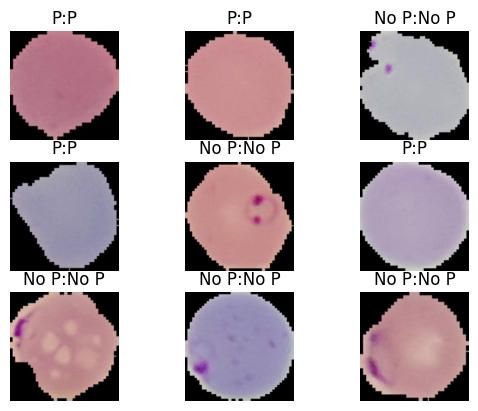

In [148]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')

plt.show()